# Introduction

I use this notebook to work myself into TensorFlow:

https://www.tensorflow.org/

Here I show how to use TensorFlow in order to

- compute gradients
- learn how to add or subtract two inputs

# Computing gradients with TensorFlow

## Display TensorFlow version

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.4.1'

## A mini computation graph

In [3]:
a = tf.constant(3)
b = tf.constant(4)

In [4]:
print(a)

tf.Tensor(3, shape=(), dtype=int32)


In [5]:
print(b)

tf.Tensor(4, shape=(), dtype=int32)


In [6]:
a+b

<tf.Tensor: shape=(), dtype=int32, numpy=7>

In [7]:
c = a+b

In [8]:
print(c)

tf.Tensor(7, shape=(), dtype=int32)


In [9]:
c.numpy()

7

## Reuse the computation graph?

In [10]:
a = tf.constant(10)
b = tf.constant(20)

In [11]:
print(a)

tf.Tensor(10, shape=(), dtype=int32)


In [12]:
print(b)

tf.Tensor(20, shape=(), dtype=int32)


In [13]:
c

<tf.Tensor: shape=(), dtype=int32, numpy=7>

## A reusable computation graph

In [14]:
a = tf.Variable(3)
b = tf.Variable(4)

In [15]:
print(a)

<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=3>


In [16]:
print(b)

<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=4>


In [17]:
c = a+b

In [18]:
print(c)

tf.Tensor(7, shape=(), dtype=int32)


In [19]:
a.assign(10)

<tf.Variable 'UnreadVariable' shape=() dtype=int32, numpy=10>

In [20]:
b.assign(10)

<tf.Variable 'UnreadVariable' shape=() dtype=int32, numpy=10>

In [21]:
c

<tf.Tensor: shape=(), dtype=int32, numpy=7>

In [22]:
def compute(a,b):
    c = a+b
    return c

In [23]:
a.assign(10)
b.assign(20)
result = compute(a,b)
result

<tf.Tensor: shape=(), dtype=int32, numpy=30>

In [24]:
id(result)

139782210231984

In [25]:
a.assign(30)
b.assign(30)
result = compute(a,b)
result

<tf.Tensor: shape=(), dtype=int32, numpy=60>

In [26]:
id(result)

139782508845536

We can see: now `c` is always a new tensor object!

Best practice is to *decorate* your function with `@tf.function`:

In [27]:
@tf.function
def compute(a,b):
    c = a+b
    return c

In [28]:
a.assign(10)
b.assign(20)
result = compute(a,b)
result

<tf.Tensor: shape=(), dtype=int32, numpy=30>

In [29]:
id(result)

139782508849984

In [30]:
a.assign(30)
b.assign(30)
result = compute(a,b)
result

<tf.Tensor: shape=(), dtype=int32, numpy=60>

In [31]:
id(result)

139782508768768

See https://www.tensorflow.org/api_docs/python/tf/function

## Gradient tapes

What are *gradient tapes?*

See here:

https://www.tensorflow.org/guide/autodiff

    Computing gradients

    To differentiate automatically, TensorFlow needs to remember what operations happen in what order during the forward pass. Then, during the backward pass, TensorFlow traverses this list of operations in reverse order to compute gradients.
    
    Gradient tapes
    TensorFlow provides the tf.GradientTape API for automatic differentiation; that is, computing the gradient of a computation with respect to some inputs, usually tf.Variables. TensorFlow "records" relevant operations executed inside the context of a tf.GradientTape onto a "tape". TensorFlow then uses that tape to compute the gradients of a "recorded" computation using reverse mode differentiation.

## A gradient computation example

In [32]:
x = tf.constant(3.0)
with tf.GradientTape() as t:
  t.watch(x)
  y = x * x
dy_dx = t.gradient(y, x) # Will compute to 6.0

In [33]:
dy_dx

<tf.Tensor: shape=(), dtype=float32, numpy=6.0>

In [34]:
y

<tf.Tensor: shape=(), dtype=float32, numpy=9.0>

In [35]:
x

<tf.Tensor: shape=(), dtype=float32, numpy=3.0>

## Importance of the `watch()` function

Note that the statement `t.watch(x)` is important. If we omit it, the tape has not stored any information in order to compute the gradient of $y=x^2$:

In [36]:
x = tf.constant(3.0)
with tf.GradientTape() as t:
  #t.watch(x)
  y = x * x
dy_dx = t.gradient(y, x) # Will compute to 6.0

In [37]:
dy_dx

In [38]:
print(dy_dx)

None


In [39]:
type(dy_dx)

NoneType

## Automatically watched tensors

Some tensors are watched automatically, e.g. `tf.Variables`

See https://www.tensorflow.org/api_docs/python/tf/GradientTape

    Trainable variables (created by tf.Variable or tf.compat.v1.get_variable, where trainable=True is default in both cases) are automatically watched. Tensors can be manually watched by invoking the watch method on this context manager.

In [40]:
x = tf.Variable(3.0)
with tf.GradientTape() as t:
  #t.watch(x)  # <-- we now omit this statement
  y = x * x
dy_dx = t.gradient(y, x) # Will compute to 6.0

In [41]:
print(dy_dx)

tf.Tensor(6.0, shape=(), dtype=float32)


So the derivative of `y` with respect to `x` is computed, although we did not explicitly tell TensorFlow to "watch" the tensor `y`.

## Computing the derivative of more than one tensor

In the following example we do not only compute $\frac{dz}{dx}$, but also $\frac{dy}{dx}$ :

In [42]:
x = tf.constant(3.0)
with tf.GradientTape(persistent=True) as t:
#with tf.GradientTape() as t:
  t.watch(x)
  y = x * x # y=x^2
  z = y * y # z=y^2=(x^2)^2=x^4

dz_dx = t.gradient(z, x)  # 108.0 (4*x^3 at x=3 --> 4*27=108)
dy_dx = t.gradient(y, x)  # 6.0 (2*x at x=3 --> 6)

In [43]:
dz_dx

<tf.Tensor: shape=(), dtype=float32, numpy=108.0>

In [44]:
dy_dx

<tf.Tensor: shape=(), dtype=float32, numpy=6.0>

Did you notice the flag `persistent=True`?

Here is the description why we need this flag to be set:

    By default, the resources held by a GradientTape are released as soon as GradientTape.gradient() method is called. To compute multiple gradients over the same computation, create a persistent gradient tape.
    
If we do not set this flag to `True`, we will get the following `RuntimeError`:

    RuntimeError: A non-persistent GradientTape can only be used tocompute one set of gradients (or jacobians)

# A Perceptron in TensorFlow

## Define a model

Here we implement a Perceptron from scratch without using Keras.

An example how to do so can also be found here:

https://adventuresinmachinelearning.com/python-tensorflow-tutorial/

In [168]:
class NN:
    
    def __init__(self, nr_inputs, nr_outputs):
        self.nr_inputs = nr_inputs
        self.nr_outputs = nr_outputs
        self.W1 = tf.Variable( tf.random.normal((nr_inputs, nr_outputs),
                               stddev=0.1),
                               name="W1"
                             )
        self.b1 = tf.Variable( tf.zeros((1, nr_outputs) ), name="b1" )
    
    
    def __call__(self, x):
        x_tf = tf.cast(x, dtype=tf.float32)
        o1 = tf.matmul(x_tf, self.W1) + self.b1        
        return o1

In [169]:
def loss_fn(y_true, y_pred):    
    loss = tf.losses.mean_squared_error(y_true, y_pred)
    return loss

In [186]:
optimizer = tf.keras.optimizers.SGD(lr=0.01)

## Using a fresh NN with random weights

In [187]:
P = NN(2,1)

In [188]:
type(P)

__main__.NN

In [189]:
P.W1

<tf.Variable 'W1:0' shape=(2, 1) dtype=float32, numpy=
array([[ 0.1573011],
       [-0.0117134]], dtype=float32)>

In [190]:
P.b1

<tf.Variable 'b1:0' shape=(1, 1) dtype=float32, numpy=array([[0.]], dtype=float32)>

In [191]:
import numpy
x1 = 1.0
x2 = 2.0
input_vec = numpy.array( [[x1,x2]] )
pred = P(input_vec)
pred

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.13387431]], dtype=float32)>

## Train the model

In [192]:
import numpy

P = NN(2,1)

NR_TRAIN_STEPS = 10000

list_of_errors = []
list_of_avg_errors = []

for train_step in range(NR_TRAIN_STEPS):
            
    if train_step % 1000 == 0:
        print("train_step=", train_step)
    
    # generate a training sample
    x1 = numpy.random.rand()
    x2 = numpy.random.rand()
    y_true = x1+x2    
    input_vec = numpy.array( [[x1,x2]] )
    
    with tf.GradientTape() as tape:
        
        # feed-forward step
        y_pred = P(input_vec)        
        
        # compute loss
        loss = loss_fn(y_true, y_pred)
    
    # save current loss for plotting it later
    list_of_errors.append( loss.numpy() )    
    if len(list_of_errors) > 100 :
        list_of_avg_errors.append( numpy.mean(list_of_errors[-100:]) )
            
    # automatically compute the gradient (autodiff!)
    # of the loss with respect to a list of model parameters
    gradient = tape.gradient(loss, [P.W1, P.b1])
        
    # apply gradient with the help of the
    # prepared optimizer
    optimizer.apply_gradients(zip(gradient, [P.W1, P.b1]))
        
print("\nTraining complete!")

train_step= 0
train_step= 1000
train_step= 2000
train_step= 3000
train_step= 4000
train_step= 5000
train_step= 6000
train_step= 7000
train_step= 8000
train_step= 9000

Training complete!


## Plot the loss curve

In [193]:
list_of_avg_errors[:20]

[0.19925492,
 0.19424377,
 0.1759298,
 0.17331131,
 0.16382025,
 0.15969005,
 0.15287302,
 0.14463891,
 0.13933538,
 0.13852428,
 0.13454585,
 0.12942055,
 0.1246456,
 0.119021006,
 0.119369745,
 0.1183788,
 0.118400164,
 0.11433703,
 0.11306117,
 0.10948318]

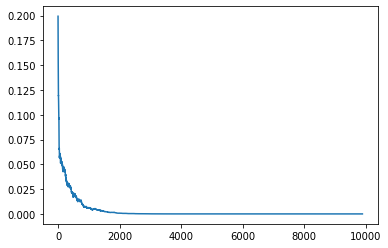

In [194]:
import matplotlib.pyplot as plt

plt.plot( list_of_avg_errors )
plt.show()

## Test the Perceptron

In [195]:
P( numpy.array( [[0.5, 0.5]] ) ).numpy()

array([[1.0000007]], dtype=float32)

In [196]:
P( numpy.array( [[0.1, 0.3]] ) ).numpy()

array([[0.40000623]], dtype=float32)

In [197]:
P( numpy.array( [[0.3, 0.2]] ) ).numpy()

array([[0.50000525]], dtype=float32)

In [198]:
P( numpy.array( [[1.0, 1.0]] ) ).numpy()

array([[1.9999915]], dtype=float32)